In [1]:
library(dplyr)
library(tibble)
library(tidyr)

library(Biobase)
library(pvca)

library(ggplot2)
library(cowplot)
theme_set(theme_bw())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
  

In [2]:
options(repr.plot.width = 6, repr.plot.height = 4)

In [12]:
# source files
src_files <- list.files('../../relapse_prediction/R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}
source("../R/rvp.R")
source("../R/gpca.R")

Sourced file: ../../relapse_prediction/R/batch.R
Sourced file: ../../relapse_prediction/R/calc.R
Sourced file: ../../relapse_prediction/R/misc.R
Sourced file: ../../relapse_prediction/R/normalise.R
Sourced file: ../../relapse_prediction/R/plot.R
Sourced file: ../../relapse_prediction/R/predict.R
Sourced file: ../../relapse_prediction/R/subset.R
Sourced file: ../../relapse_prediction/R/utils.R


In [4]:
#' @param X Dataframe of dim (n_features, n_samples)
quantify_batch <- function(X, metadata) {
  batch <- metadata[colnames(X), 'batch']
  class <- metadata[colnames(X), 'class']

  rvp <- RVP(t(X), batch, class)
  gpca <- gPCA.batchdetect(t(X), batch)
    
  # create expressionset from biobase package
  meta_metadata <- data.frame(labelDescription = colnames(metadata))
  pheno_data <- new(
    "AnnotatedDataFrame",
    data = metadata, varMetadata = meta_metadata
  )
  eset <- ExpressionSet(assayData = as.matrix(X), phenoData = pheno_data)
  pvca_obj <- pvcaBatchAssess(eset, c('batch', 'class'), 0.6)
  var_pcts <- as.vector(pvca_obj$dat)
  names(var_pcts) <- as.vector(pvca_obj$label)

  c(
    gpca = gpca$delta,
    pvca = var_pcts['batch'],
    rvp = rvp
  )
}

# Measuring batch effects
- Different batch-class imbalance
- No batch effects
- Different magnitude of batch effects when there is batch-class imbalance
- Measure when there is different number of features
- Different batch sizes

### Comparisons
- gPCA delta: 0-1 (proportion of variance)
    - Weak in quantifying small amounts of batch effects?
    - Problems when there is no batch effects but there is class imbalance

# BatchQC - Different batch delta

## Theoretical variance - Different batch delta
- Measures the sample variance of vector of differences for feature $i$ where each element is $E(X_{ijkg}' - X_{ijkg})$

In [22]:
# Computes variance due to batch effects in a balanced two-batch two-class dataset
calc_batch_var <- function(delta, n, p) p * n / (n - 1) * (delta / 2)^2

batch_deltas <- seq(0, 10000, 1000)
p <- 8000
n <- 80

# variance due to batch effects
theoretical_batchvar <- sapply(batch_deltas, calc_batch_var, n, p)
names(theoretical_batchvar) <- batch_deltas

## Balanced
- Additive batch effects. Sampled from poisson distribution

In [6]:
dir <- '../data/batchqc/small/additive/balanced'
files <- list.files(dir, full.names = T)
files <- files[c(1:2, 4:11, 3)]
print(files)
list_data <- lapply(files, read.table, sep = "\t", header = T, row.names = 1)

 [1] "../data/batchqc/small/additive/balanced/bal-0.tsv"    
 [2] "../data/batchqc/small/additive/balanced/bal-1000.tsv" 
 [3] "../data/batchqc/small/additive/balanced/bal-2000.tsv" 
 [4] "../data/batchqc/small/additive/balanced/bal-3000.tsv" 
 [5] "../data/batchqc/small/additive/balanced/bal-4000.tsv" 
 [6] "../data/batchqc/small/additive/balanced/bal-5000.tsv" 
 [7] "../data/batchqc/small/additive/balanced/bal-6000.tsv" 
 [8] "../data/batchqc/small/additive/balanced/bal-7000.tsv" 
 [9] "../data/batchqc/small/additive/balanced/bal-8000.tsv" 
[10] "../data/batchqc/small/additive/balanced/bal-9000.tsv" 
[11] "../data/batchqc/small/additive/balanced/bal-10000.tsv"


In [7]:
ids <- files %>%
  sapply(function(x) substring(x, 45), USE.NAMES = F) %>%
  sapply(function(x) strsplit(x, '\\.')[[1]][[1]], USE.NAMES = F)
print(ids)
names(list_data) <- ids

 [1] "0"     "1000"  "2000"  "3000"  "4000"  "5000"  "6000"  "7000"  "8000" 
[10] "9000"  "10000"


In [8]:
# metadata
ncond <- 20
batch <- as.factor(rep(1:2, each = ncond * 2))
class <- rep(rep(LETTERS[1:2], each = ncond), 2)
metadata <- data.frame(batch, class, row.names = colnames(list_data[[1]]))

In [13]:
list_metrics <- lapply(list_data, quantify_batch, metadata)

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) 

In [14]:
metrics <- list_metrics %>%
  data.frame() %>%
  t() %>%
  data.frame()
rownames(metrics) <- substring(rownames(metrics), 2)

### Measured batch effects variance
- Sample variance of additive batch effect terms
- I.e. $\mathrm{Var}(X' - X) = \mathrm{Var}(\omega_{ijkg})$

In [42]:
var_matrix <- function(X, axis = 1) {
  sigma2 <- apply(X, axis, var)
  sum(sigma2)
}

list_deltas <- lapply(list_data, function(X) X - list_data[[1]])
measured_batchvar <- sapply(list_deltas, var_matrix)
var_bal <- sapply(list_data, var_matrix)
metrics_var_bal <- cbind(
  metrics,
  var_total = var_bal,
  theoretical_batchvar,
  measured_batchvar
)

### Plots

#### Measured v.s. Theoretical

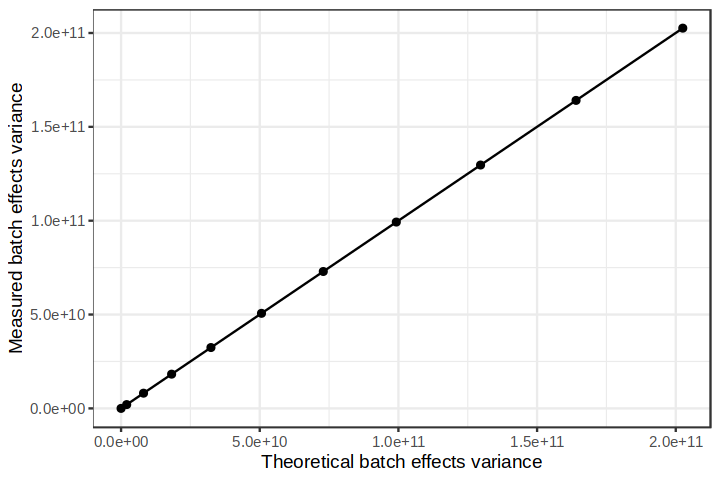

In [45]:
ax <- ggplot(
  metrics_var_bal,
  aes(x = theoretical_batchvar, y = measured_batchvar)
) +
  geom_point() +
  geom_line() +
  labs(
    x = "Theoretical batch effects variance",
    y = "Measured batch effects variance"
  )
ax
file <- '~/Dropbox/tmp/additive_bal-measured_theoretical.pdf'
ggsave(file, ax, width = 3.5, height = 3)

#### Theoretical batch effects variance (combined)

In [165]:
ggcols <- ggplot_palette(3)
names(ggcols) <- c('RVP', 'gPCA', 'PVCA')

var_gpca_lab <- expression(paste("gPCA ", delta, " * ", S[bold(X)]^2))
var_pvca_lab <- expression(paste("PVCA * ", S[bold(X)]^2))
var_rvp_lab <- expression(paste("RVP * ", S[bold(X)]^2))

var_labs <- c(var_gpca_lab, var_pvca_lab, var_rvp_lab)
lab_theoretical <- "Theoretical batch effects variance"
lab_metric <- "Batch effects variance (est. by metrics)"

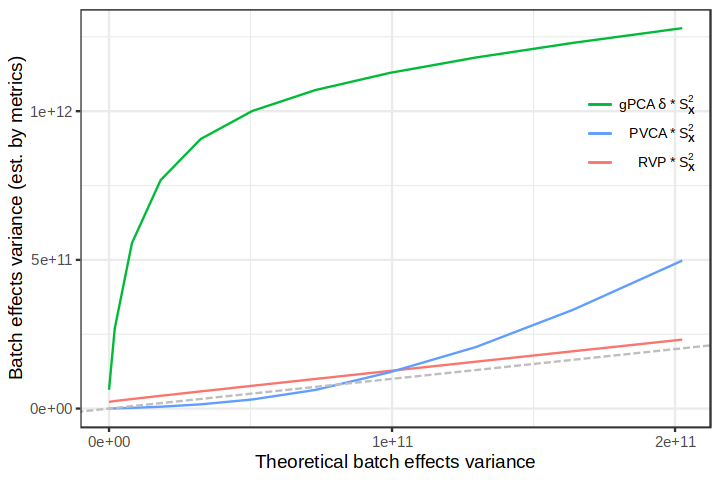

In [166]:
ax <- ggplot(metrics_var_bal) +
  geom_line(aes(x = theoretical_batchvar, y = rvp * var_total, col = 'RVP')) + 
  geom_line(aes(x = theoretical_batchvar, y = gpca * var_total, col = 'gPCA')) + 
  geom_line(aes(x = theoretical_batchvar, y = pvca.batch * var_total, col = 'PVCA')) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = lab_theoretical, y = lab_metric) +
  scale_color_manual(values = ggcols, labels = var_labs) +
  scale_x_continuous(breaks = seq(0, 2e11, by = 1e11)) +
  theme(
    legend.text = element_text(size = 8),
    legend.position = c(.99, .85),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.key = element_rect(fill='transparent'),
    legend.background = element_rect(fill='transparent'),
    legend.title = element_blank()
  )
ax

In [167]:
file <- '~/Dropbox/tmp/var_bal.pdf'
ggsave(file, ax, width = 3.5, height = 3)

#### Theoretical batch effects variance (individual)

In [84]:
ax <- ggplot(metrics_var_bal) +
  geom_line(aes(
    x = theoretical_batchvar,
    y = rvp * var_total,
    col = 'RVP'
  ), show.legend = F) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  scale_color_manual(values = ggcols) +
  scale_x_continuous(breaks = seq(0, 2e11, by = 1e11)) +
  theme(text = element_text(size = 10)) +
  labs(x = lab_theoretical, y = var_rvp_lab) +
  ylim(0, 2.4e11)

In [86]:
file <- '~/Dropbox/tmp/var_bal-rvp.pdf'
ggsave(file, ax, width = 3, height = 2.5)

### Percentage of batch effects in data

In [93]:
calc_pct_expression <- function(
  delta_k, psi_g, phi_i,
  p, n, alpha, epsilon,
  ret.obj = F
) {
  if (length(phi_i) != p)
    stop(sprintf("phi_i has to be of length %d.", p))
  
  # Assumption: Two batches with same size and two classes with same size  
  n_k <- n / 2 
  n_g <- n / 2
  exp_omega <- p * n_k * delta_k
  exp_x <- p * n * alpha +
    p * n * epsilon * 0.5 +
    p * n_g * psi_g +
    n * sum(phi_i)
  
  exp_omega / exp_x
}

In [95]:
# nbatch <- 2
# ncond <- 2
# npercond <- 20
n <- 80
ngenes <- 8000

basemean <- 5000
basedisp <- 2000
ggstep <- 100
bdispstep <- 0
swvar <- 2000

class_step <- 10000
batch_step <- seq(0, 10000, by = 1000)
feature_step <- seq(0, length.out = ngenes, by = ggstep)

pct_magnitude <- sapply(
  batch_step,
  calc_pct_expression,
  class_step, feature_step,
  ngenes, n, basemean, swvar
)
names(pct_magnitude) <- batch_deltas

In [105]:
metrics_percentage <- cbind(
  metrics, data.frame(pct_magnitude)
)

#### Measured v.s. theoretical percentage of batch effects
- Measured: Sum of additive batch effects / sum of original counts

In [140]:
X_original <- list_data[[1]]

In [145]:
measured_pct <- sapply(list_deltas,
  function(omega) sum(omega) / sum(X_original)
)
measured_theoretical_pct <- data.frame(
  theoretical_pct = metrics_percentage$pct_magnitude,
  measured_pct
)

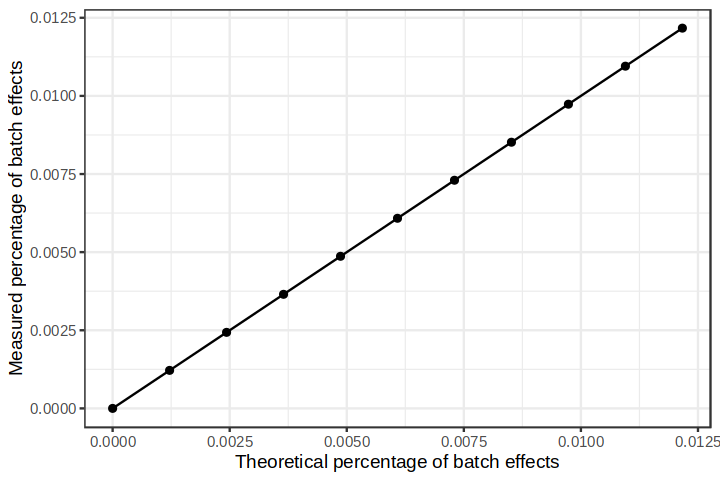

In [147]:
ax <- ggplot(
  measured_theoretical_pct,
  aes(x = theoretical_pct, y = measured_pct)
) +
  geom_point() +
  geom_line() +
  labs(
    x = "Theoretical percentage of batch effects",
    y = "Measured percentage of batch effects"
  )
ax
file <- '~/Dropbox/tmp/additive_pct_bal-measured_theoretical.pdf'
ggsave(file, ax, width = 3.5, height = 3)

#### Percentage of batch effects in data (combined)

In [119]:
xlab <- 'Percentage of batch effects in data'
ylab <- 'Metric value'
gpca_lab <- expression(paste("gPCA ", delta))
metric_labs <- c(gpca_lab, 'PVCA', 'RVP')

ax <- ggplot(metrics_percentage) +
  geom_line(aes(x = pct_magnitude, y = rvp, col = 'RVP')) + 
  geom_line(aes(x = pct_magnitude, y = gpca, col = 'gPCA')) + 
  geom_line(aes(x = pct_magnitude, y = pvca.batch, col = 'PVCA')) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = 'Percentage of batch effects in data', y = 'Metric value') +
  scale_x_continuous(breaks = seq(0, 0.01, by = 0.005)) +
  ylim(0, 1) +
  labs(x = xlab, y = ylab) +
  scale_color_manual(values = ggcols, labels = metric_labs) +
  theme(
    legend.text = element_text(size = 8),
    legend.position = c(.99, .85),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.key = element_rect(fill='transparent'),
    legend.background = element_rect(fill='transparent'),
    legend.title = element_blank()
  )

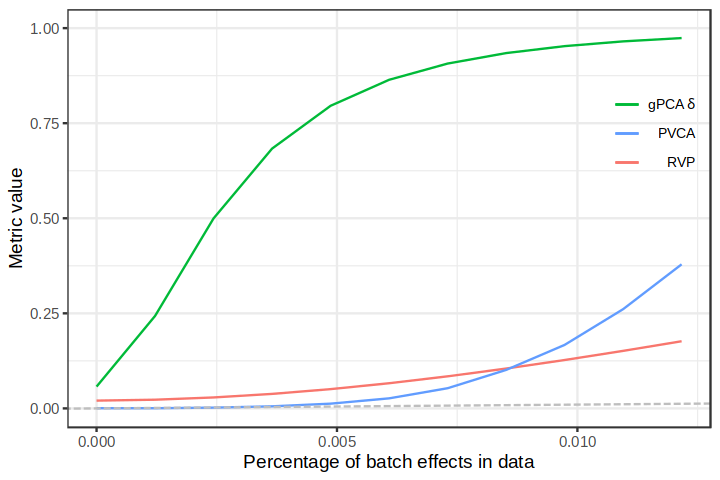

In [120]:
ax

In [121]:
file <- '~/Dropbox/tmp/pct_magnitude_bal.pdf'
ggsave(file, ax, width = 3.5, height = 3)

#### Percentage of batch effects in data (individual)

In [136]:
gpca_lab <- expression(paste("gPCA ", delta))
xlab <- 'Percentage of batch effects in data'

metric <- 'RVP'
ax <- ggplot(metrics_percentage) +
  geom_line(aes(x = pct_magnitude, y = rvp, col = metric), show.legend = F) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = xlab, y = metric) +
  scale_color_manual(values = ggcols, labels = metric) +
  scale_x_continuous(breaks = seq(0, 0.01, by = 0.005)) +
  ylim(0, .18)

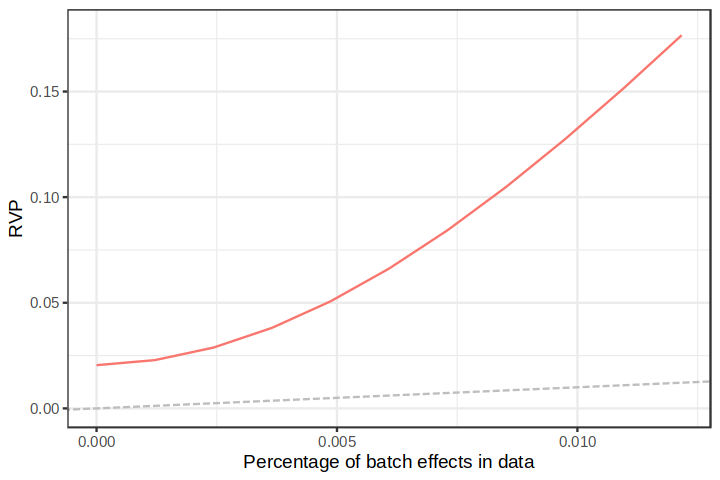

In [137]:
ax

In [138]:
file <- '~/Dropbox/tmp/pct_magnitude_bal-rvp.pdf'
ggsave(file, ax, width = 3, height = 2.5)

## Imbalanced

In [148]:
dir <- '../data/batchqc/small/additive/imbalanced'
files <- list.files(dir, full.names = T)
files <- files[c(1:2, 4:11, 3)]
print(files)
list_data <- lapply(files, read.table, sep = "\t", header = T, row.names = 1)

 [1] "../data/batchqc/small/additive/imbalanced/imbal-0.tsv"    
 [2] "../data/batchqc/small/additive/imbalanced/imbal-1000.tsv" 
 [3] "../data/batchqc/small/additive/imbalanced/imbal-2000.tsv" 
 [4] "../data/batchqc/small/additive/imbalanced/imbal-3000.tsv" 
 [5] "../data/batchqc/small/additive/imbalanced/imbal-4000.tsv" 
 [6] "../data/batchqc/small/additive/imbalanced/imbal-5000.tsv" 
 [7] "../data/batchqc/small/additive/imbalanced/imbal-6000.tsv" 
 [8] "../data/batchqc/small/additive/imbalanced/imbal-7000.tsv" 
 [9] "../data/batchqc/small/additive/imbalanced/imbal-8000.tsv" 
[10] "../data/batchqc/small/additive/imbalanced/imbal-9000.tsv" 
[11] "../data/batchqc/small/additive/imbalanced/imbal-10000.tsv"


In [149]:
ids <- files %>%
  sapply(function(x) substring(x, 49), USE.NAMES = F) %>%
  sapply(function(x) strsplit(x, '\\.')[[1]][[1]], USE.NAMES = F)
print(ids)
names(list_data) <- ids

 [1] "0"     "1000"  "2000"  "3000"  "4000"  "5000"  "6000"  "7000"  "8000" 
[10] "9000"  "10000"


In [150]:
# metadata
ncond <- 30
batch <- as.factor(rep(1:2, each = ncond * 2))
class <- rep(rep(LETTERS[1:2], each = ncond), 2)
metadata <- data.frame(batch, class, row.names = colnames(list_data[[1]]))

In [151]:
# subsampling
# severe imbalance (1:3)
idx <- c(seq(21, 100))

metadata_imbal <- metadata[idx, ]
print(table(metadata_imbal))
list_imbal <- lapply(list_data, function(X) X[, idx])

     class
batch  A  B
    1 10 30
    2 30 10


In [152]:
list_metrics_imbal <- lapply(list_imbal, quantify_batch, metadata_imbal)

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) 

In [222]:
metrics_imbal <- list_metrics_imbal %>%
  data.frame() %>%
  t() %>%
  data.frame()
rownames(metrics_imbal) <- substring(rownames(metrics_imbal), 2)

#### Measured batch effects variance

In [214]:
X_original_imbal <- list_imbal[[1]]
list_imbal_deltas <- lapply(list_imbal, function(X) X - X_original_imbal)
measured_batchvar_imbal <- sapply(list_imbal_deltas, var_matrix)
var_imbal <- sapply(list_imbal, var_matrix)
metrics_var_imbal <- cbind(
  metrics_imbal,
  var_total = var_imbal,
  theoretical_batchvar,
  measured_batchvar = measured_batchvar_imbal
)

### Plots

#### Measured v.s. theoretical

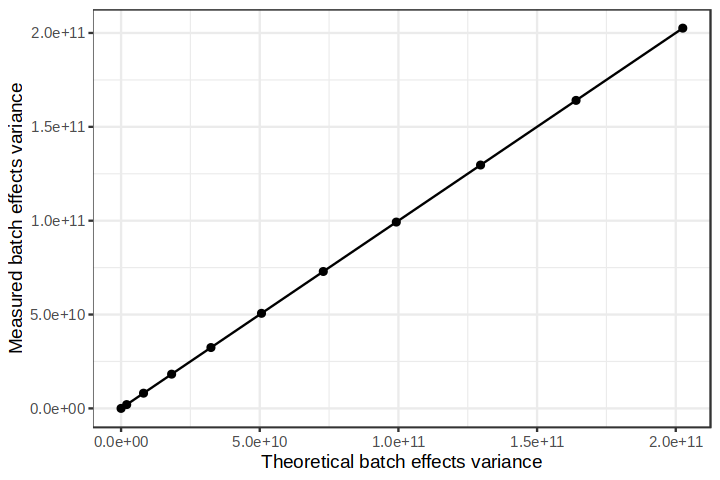

In [157]:
ax <- ggplot(
  metrics_var_imbal,
  aes(x = theoretical_batchvar, y = measured_batchvar)
) +
  geom_point() +
  geom_line() +
  labs(
    x = "Theoretical batch effects variance",
    y = "Measured batch effects variance"
  )
ax

In [158]:
file <- '~/Dropbox/tmp/var_imbal-measured_theoretical.pdf'
ggsave(file, ax, width = 3.5, height = 3)

#### Theoretical batch effects variance (combined)

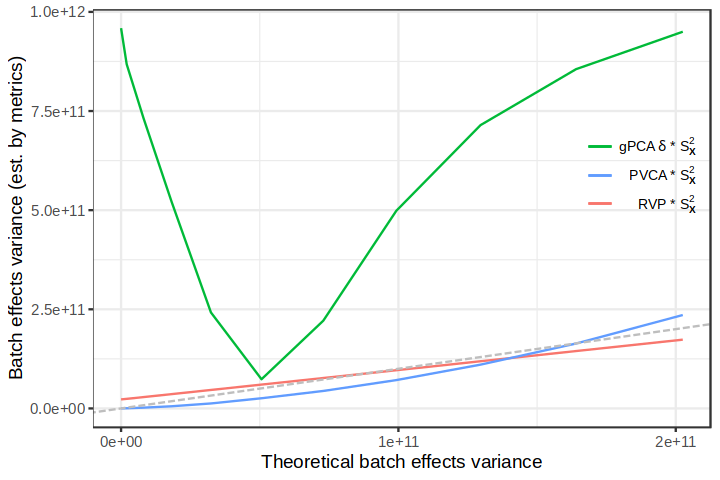

In [168]:
ax <- ggplot(metrics_var_imbal) +
  geom_line(aes(x = theoretical_batchvar, y = rvp * var_total, col = 'RVP')) + 
  geom_line(aes(x = theoretical_batchvar, y = gpca * var_total, col = 'gPCA')) + 
  geom_line(aes(x = theoretical_batchvar, y = pvca.batch * var_total, col = 'PVCA')) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = lab_theoretical, y = lab_metric) +
  scale_color_manual(values = ggcols, labels = var_labs) +
  scale_x_continuous(breaks = seq(0, 2e11, by = 1e11)) +
  theme(
    legend.text = element_text(size = 8),
    legend.position = c(.99, .75),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.key = element_rect(fill='transparent'),
    legend.background = element_rect(fill='transparent'),
    legend.title = element_blank()
  )
ax

In [169]:
file <- '~/Dropbox/tmp/var_imbal.pdf'
ggsave(file, ax, width = 3.5, height = 3)

#### Theoretical batch effects variance (individual)

In [210]:
metric <- 'PVCA'
ax <- ggplot(metrics_var_imbal) +
  geom_line(aes(x = theoretical_batchvar, y = pvca.batch * var_total, col = metric), show.legend = F) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = lab_theoretical, y = var_pvca_lab) +
  scale_x_continuous(breaks = seq(0, 2e11, by = 1e11)) +
  scale_color_manual(values = ggcols, labels = metric) +
  theme(text = element_text(size = 10)) +
  ylim(0, 2.4e11)

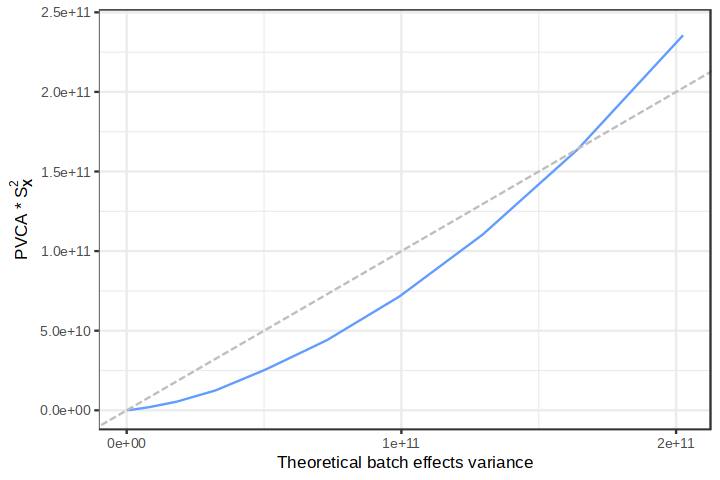

In [211]:
ax

In [212]:
file <- '~/Dropbox/tmp/var_imbal-pvca.pdf'
ggsave(file, ax, width = 3, height = 2.5)

#### Measured percentage of batch effects in data

In [217]:
measured_pct_imbal <- sapply(list_imbal_deltas,
  function(omega) sum(omega) / sum(X_original_imbal)
)
measured_theoretical_pct_imbal <- data.frame(
  theoretical_pct = pct_magnitude,
  measured_pct = measured_pct_imbal
)

In [221]:
head(metrics)

,gpca,pvca.batch,rvp
,<dbl>,<dbl>,<dbl>
0,0.05731282,0.0005328856,0.02047411
1000,0.24316782,0.0004966632,0.02287490
2000,0.49971692,0.0020291986,0.02880984
3000,0.68322266,0.0054589645,0.03815061
4000,0.79580009,0.0124909161,0.05069973
5000,0.86417318,0.0264394644,0.06619819


In [225]:
pct_magnitude

0        1000        2000        3000        4000        5000 
0.000000000 0.001216693 0.002433386 0.003650079 0.004866772 0.006083465 
       6000        7000        8000        9000       10000 
0.007300158 0.008516851 0.009733544 0.010950237 0.012166930

In [232]:
metrics_pct_imbal <- cbind(metrics_imbal, pct_magnitude)

In [227]:
head(metrics_imbal_magnitude)

,gpca,pvca.batch,rvp,pct_magnitude
,<dbl>,<dbl>,<dbl>,<dbl>
0,0.87361995,5.643399e-05,0.02074023,0.000000000
1000,0.80413811,3.748859e-04,0.02238781,0.001216693
2000,0.68701064,1.830370e-03,0.02685327,0.002433386
3000,0.49383253,5.156405e-03,0.03419867,0.003650079
4000,0.23073365,1.196034e-02,0.04441930,0.004866772
5000,0.07031082,2.451815e-02,0.05744852,0.006083465


### Plots

#### Measured v.s. Theoretical

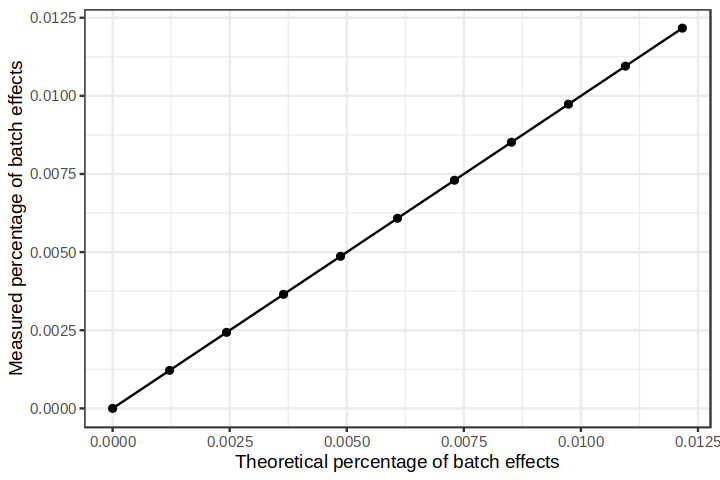

In [230]:
ax <- ggplot(
  measured_theoretical_pct_imbal,
  aes(x = theoretical_pct, y = measured_pct)
) +
  geom_point() +
  geom_line() +
  labs(
    x = "Theoretical percentage of batch effects",
    y = "Measured percentage of batch effects"
  )
ax

In [231]:
file <- '~/Dropbox/tmp/pct_magnitude_imbal-measured_theoretical.pdf'
ggsave(file, ax, width = 3.5, height = 3)

#### Percentage of batch effects in data (combined)

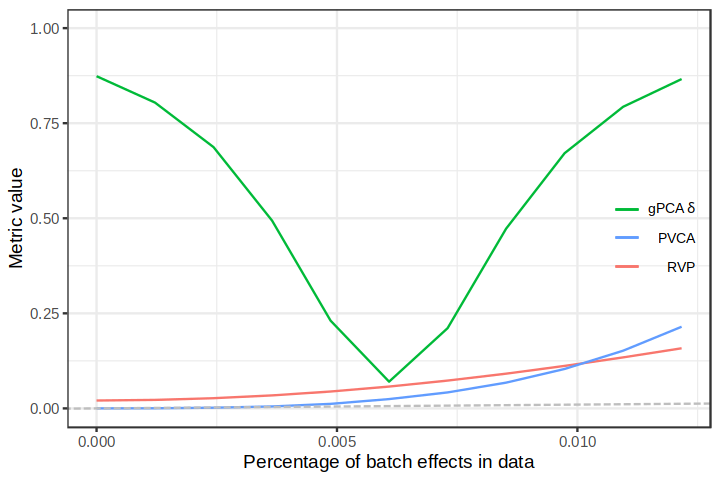

In [267]:
xlab <- 'Percentage of batch effects in data'
ylab <- 'Metric value'
gpca_lab <- expression(paste("gPCA ", delta))
metric_labs <- c(gpca_lab, 'PVCA', 'RVP')

ax <- ggplot(metrics_pct_imbal) +
  geom_line(aes(x = pct_magnitude, y = rvp, col = 'RVP')) + 
  geom_line(aes(x = pct_magnitude, y = gpca, col = 'gPCA')) + 
  geom_line(aes(x = pct_magnitude, y = pvca.batch, col = 'PVCA')) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = 'Percentage of batch effects in data', y = 'Metric value') +
  scale_x_continuous(breaks = seq(0, 0.01, by = 0.005)) +
  ylim(0, 1) +
  labs(x = xlab, y = ylab) +
  scale_color_manual(values = ggcols, labels = metric_labs) +
  theme(
    legend.text = element_text(size = 8),
    legend.position = c(.99, .6),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.key = element_rect(fill='transparent'),
    legend.background = element_rect(fill='transparent'),
    legend.title = element_blank()
  )
ax

In [90]:
# gpca_lab <- expression(paste("gPCA ", delta))
# metric_labs <- c(gpca_lab, 'PVCA', 'RVP')

# xlab <- 'Percentage of batch effects in data'
# ylab <- 'Metric value'

# ax <- ggplot(metrics_imbal_magnitude) +
#   geom_line(aes(x = pct_magnitude, y = rvp, col = 'RVP')) + 
#   geom_line(aes(x = pct_magnitude, y = gpca, col = 'gPCA')) + 
#   geom_line(aes(x = pct_magnitude, y = pvca.batch, col = 'PVCA')) + 
#   geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
#   labs(x = 'Percentage of batch effects in data', y = 'Metric value') +
#   scale_x_continuous(breaks = seq(0, 0.01, by = 0.005)) +
#   ylim(0, 1) +
#   labs(x = xlab, y = ylab) +
#   scale_color_manual(values = ggcols, labels = metric_labs) +
#   theme(
#     legend.text = element_text(size = 8),
#     legend.position = c(.99, .58),
#     legend.justification = c("right", "top"),
#     legend.box.just = "right",
#     legend.key = element_rect(fill='transparent'),
#     legend.background = element_rect(fill='transparent'),
#     legend.title = element_blank()
#   )

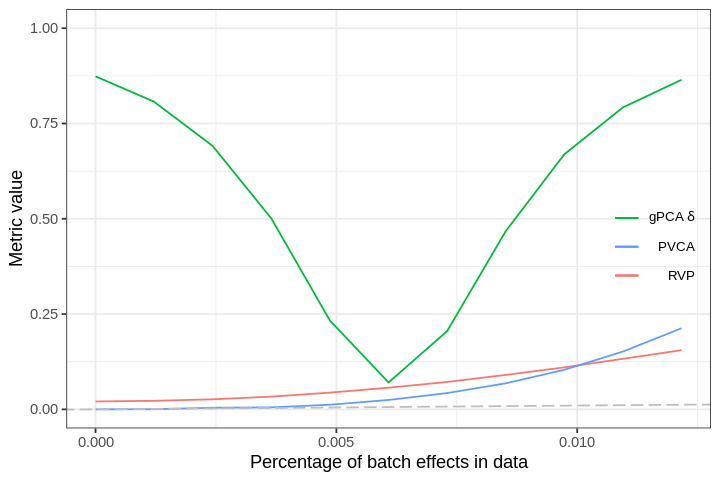

In [91]:
ax

In [268]:
file <- '~/Dropbox/tmp/pct_magnitude_imbal.pdf'
ggsave(file, ax, width = 3.5, height = 3)

#### Percentage of batch effects in data (individual)

In [260]:
gpca_lab <- expression(paste("gPCA ", delta))
xlab <- 'Percentage of batch effects in data'

metric <- 'gPCA'
ax <- ggplot(metrics_pct_imbal) +
  geom_line(aes(x = pct_magnitude, y = gpca, col = metric), show.legend = F) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = xlab, y = gpca_lab) +
  scale_color_manual(values = ggcols, labels = metric) +
  scale_x_continuous(breaks = seq(0, 0.01, by = 0.005)) +
  ylim(0, 1)

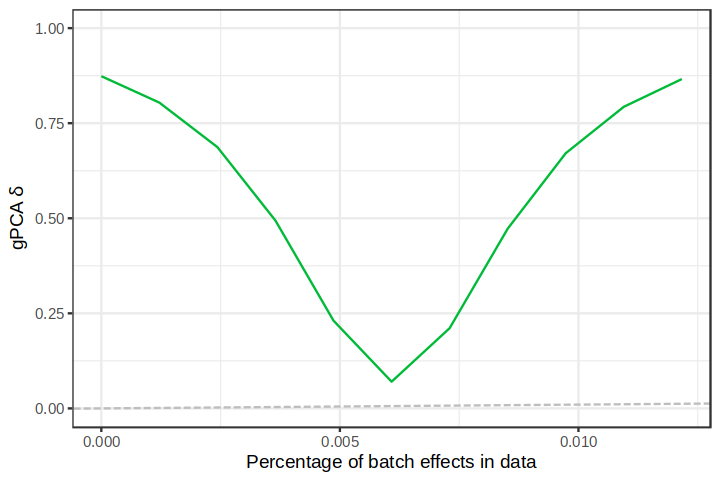

In [261]:
ax

In [262]:
file <- '~/Dropbox/tmp/pct_magnitude_imbal-gpca.pdf'
ggsave(file, ax, width = 3, height = 2.5)

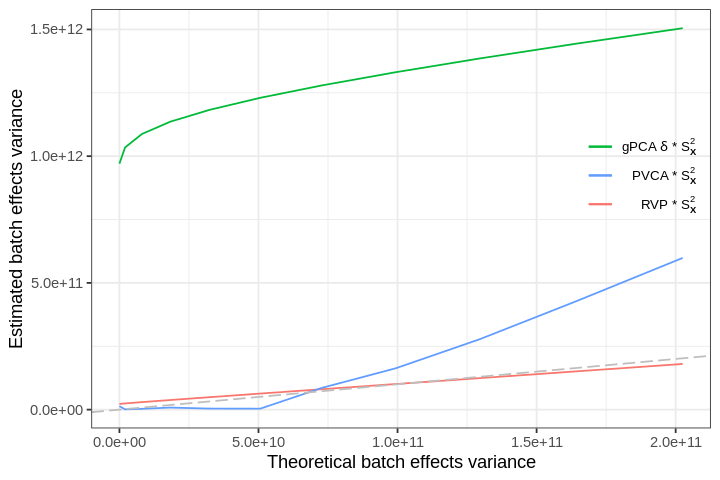

In [82]:
var_labs <- c(var_gpca_lab, var_pvca_lab, var_rvp_lab)
label1 <- 'Theoretical batch effects variance'
label2 <- 'Estimated batch effects variance'

ax <- ggplot(metrics_var_imbal1) +
  geom_line(aes(x = theoretical_batchvar, y = rvp, col = 'RVP')) + 
  geom_line(aes(x = theoretical_batchvar, y = gpca, col = 'gPCA')) + 
  geom_line(aes(x = theoretical_batchvar, y = pvca.batch * empirical_var, col = 'PVCA')) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = label1, y = label2) +
  scale_color_manual(values = ggcols, labels = var_labs) +
#   scale_x_continuous(breaks = seq(0, 2e11, by = 1e11)) +
  theme(
    legend.text = element_text(size = 8),
    legend.position = c(.99, .75),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.key = element_rect(fill='transparent'),
    legend.background = element_rect(fill='transparent'),
    legend.title = element_blank()
  )
ax

# file <- '~/Dropbox/tmp/additive_imbal1-est_theoretical.pdf'
# ggsave(file, ax, width = 4, height = 3)

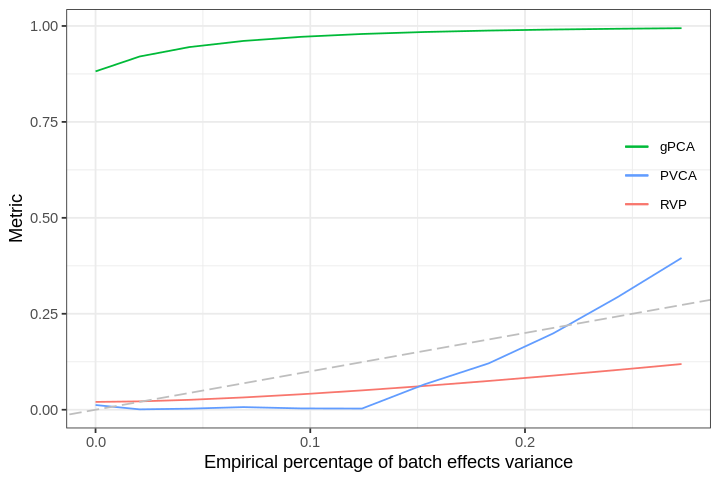

In [86]:
var_labs <- c(var_gpca_lab, var_pvca_lab, var_rvp_lab)
label1 <- 'Empirical percentage of batch effects variance'
label2 <- 'Metric'

ax <- ggplot(metrics_var_imbal1) +
  geom_line(aes(x = empirical_batchvar / empirical_var, y = rvp, col = 'RVP')) + 
  geom_line(aes(x = empirical_batchvar / empirical_var, y = gpca, col = 'gPCA')) + 
  geom_line(aes(x = empirical_batchvar / empirical_var, y = pvca.batch, col = 'PVCA')) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = label1, y = label2) +
  scale_color_manual(values = ggcols) +
#   scale_x_continuous(breaks = seq(0, 2e11, by = 1e11)) +
  theme(
    legend.text = element_text(size = 8),
    legend.position = c(.99, .75),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.key = element_rect(fill='transparent'),
    legend.background = element_rect(fill='transparent'),
    legend.title = element_blank()
  )
ax

file <- '~/Dropbox/tmp/additive_imbal1-metric_empirical_pct.pdf'
ggsave(file, ax, width = 4, height = 3)

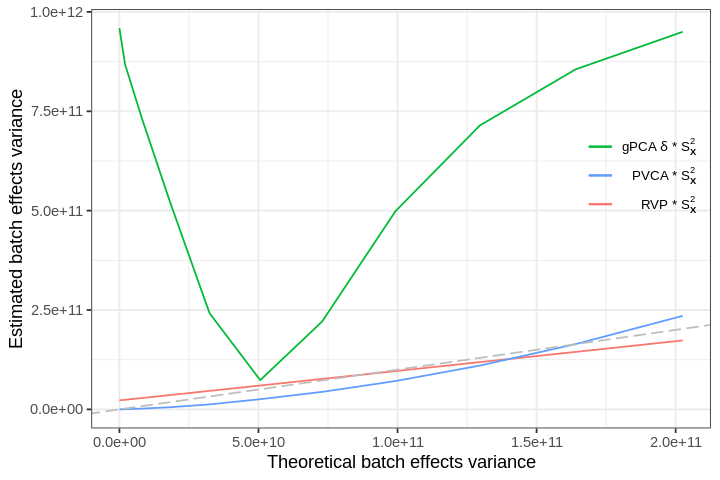

In [79]:
# TODO: Investigate
var_labs <- c(var_gpca_lab, var_pvca_lab, var_rvp_lab)
label1 <- 'Theoretical batch effects variance'
label2 <- 'Estimated batch effects variance'

ax <- ggplot(metrics_var_imbal) +
  geom_line(aes(x = theoretical_batchvar, y = rvp * empirical_var, col = 'RVP')) + 
  geom_line(aes(x = theoretical_batchvar, y = gpca * empirical_var, col = 'gPCA')) + 
  geom_line(aes(x = theoretical_batchvar, y = pvca.batch * empirical_var, col = 'PVCA')) + 
  geom_abline(slope = 1, intercept = 0, col = 'gray', linetype = 'longdash') +
  labs(x = label1, y = label2) +
  scale_color_manual(values = ggcols, labels = var_labs) +
#   scale_x_continuous(breaks = seq(0, 2e11, by = 1e11)) +
  theme(
    legend.text = element_text(size = 8),
    legend.position = c(.99, .75),
    legend.justification = c("right", "top"),
    legend.box.just = "right",
    legend.key = element_rect(fill='transparent'),
    legend.background = element_rect(fill='transparent'),
    legend.title = element_blank()
  )

ax

### Investigate

In [50]:
# opposite subsampling
idx1 <- c(1:40, 81:120)
metadata_imbal1 <- metadata[idx1, ]
list_imbal1 <- lapply(list_data, function(X) X[, idx1])

In [51]:
vars_imbal1 <- sapply(list_imbal1, var_matrix)
empirical_batchvars_imbal1 <- vars_imbal1 - vars_imbal1[1]

In [52]:
list_metrics_imbal1 <- lapply(list_imbal1, quantify_batch, metadata_imbal1)

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) 

In [53]:
metrics_imbal1 <- list_metrics_imbal1 %>%
  data.frame() %>%
  t() %>%
  data.frame()

In [54]:
metrics_var_imbal1 <- cbind(
  metrics_imbal1,
  empirical_var = vars_imbal1,
  empirical_batchvar = empirical_batchvars_imbal1,
  theoretical_batchvar = theoretical_batchvars
)

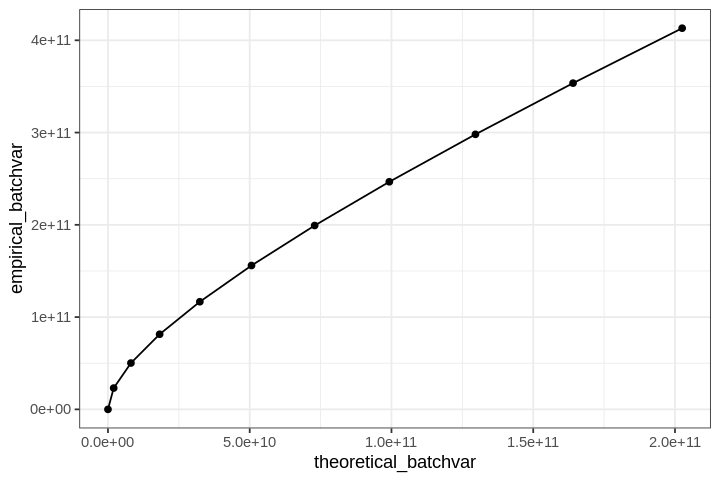

In [360]:
# comparison
ax <- ggplot(
  metrics_var_imbal1,
  aes(x = theoretical_batchvar, y = empirical_batchvar)
) +
  geom_point() +
  geom_line()
ax

file <- '~/Dropbox/tmp/additive_imbal1-empirical_theoretical.pdf'
ggsave(file, ax, width = 4, height = 3)

In [342]:
# feature
for (delta_batch in seq(0, 10000, 1000)) {
  idx <- as.character(delta_batch)
  X <- list_imbal1[[idx]]
  feature <- cbind(
    value = as.vector(data.matrix(X[1, ])),
    metadata_imbal
  )
  ax <- ggplot(feature) +
    geom_point(
      aes(x = class, y = value, color = batch),
      position = position_jitterdodge(), cex = 1.2
    ) +
    ylim(5000, 30000) +
    geom_hline(yintercept = mean(feature$value), linetype = 'longdash') +
    labs(title = sprintf('Variance = %.2e', var(feature$value)))
  
  file <- sprintf('~/Dropbox/tmp/feature1_additive_imbal1-%s.pdf', idx)
  ggsave(file, ax, width = 5, height = 3)
}

### Plots

In [ ]:
# feature
for (delta_batch in seq(0, 10000, 1000)) {
  idx <- as.character(delta_batch)
  X <- list_imbal[[idx]]
  feature <- cbind(
    value = as.vector(data.matrix(X[1, ])),
    metadata_imbal
  )
  ax <- ggplot(feature) +
    geom_point(
      aes(x = class, y = value, color = batch),
      position = position_jitterdodge(), cex = 1.2
    ) +
    ylim(5000, 30000) +
    geom_hline(yintercept = mean(feature$value), linetype = 'longdash') +
    labs(title = sprintf('Variance = %.2e', var(feature$value)))
  
  file <- sprintf('~/Dropbox/tmp/feature1_additive_imbal-%s.pdf', idx)
  ggsave(file, ax, width = 5, height = 3)
}

In [301]:
# pca
for (delta_batch in seq(0, 10000, 1000)) {
  idx <- as.character(delta_batch)
  ax <- ggplot_pca(
    list_imbal[[idx]], metadata_imbal,
    color = 'batch', pch = 'class'
  )
  ax
  file <- sprintf('~/Dropbox/tmp/pca_additive_imbal-%s.pdf', idx)
  ggsave(file, ax, width = , height = 3)
}